This notebook is used to create the runtime graphs for the BiG-SCAPE v2 paper

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="white")

COLOR_MAP = "colorblind"

sns.color_palette(COLOR_MAP)

COLORS = {
    "bigscape_blue": "#52A3A3",
    "dark_blue": "#0E75BB",
    "orange_i_found_on_bigscape_image": "#F7931E",
    "antismash_red": "#AA0000",
    "bigslice_grey": "#515154",
}

totals_colors = [
    COLORS["bigslice_grey"],
    COLORS["bigslice_grey"],
    COLORS["bigscape_blue"],
    COLORS["bigscape_blue"],
]

# make the font type editable in the svg
mpl.rcParams["svg.fonttype"] = "none"

In [ ]:
# load data
# bs1 csv: size,sample,start,hmm_scan,hmm_align,distance_calc,cc_gen,total
source_bigscape_v1_matrix = pd.read_csv("source_data/bigscape_v1_matrix.csv")

# bs2 csv: size,sample,start,hmm_scan,hmm_scan_save,hmm_align,hmm_align_save,distance_calc,cc_gen,cc_gen_save,total
source_bigscape_v2_matrix = pd.read_csv("source_data/bigscape_v2_matrix.csv")

# bigslice csvs, both are: size,sample,start,total
source_bigslice_v1_matrix = pd.read_csv("source_data/bigslice_v1_matrix.csv")
source_bigslice_v2_matrix = pd.read_csv("source_data/bigslice_v2_matrix.csv")

# 10k mode csvs
bigscape_v2_mode_10k_matrix = pd.read_csv("source_data/bigscape_v2_mode_10k_matrix.csv")

# for v2 we want to combine the saving steps with their preceding steps
source_bigscape_v2_matrix["hmm_scan"] = source_bigscape_v2_matrix["hmm_scan"] + source_bigscape_v2_matrix["hmm_scan_save"]
source_bigscape_v2_matrix["hmm_align"] = source_bigscape_v2_matrix["hmm_align"] + source_bigscape_v2_matrix["hmm_align_save"]
source_bigscape_v2_matrix["cc_gen"] = source_bigscape_v2_matrix["cc_gen"] + source_bigscape_v2_matrix["cc_gen_save"]

# then drop the saving columns
source_bigscape_v2_matrix = source_bigscape_v2_matrix.drop(columns=["hmm_scan_save", "hmm_align_save", "cc_gen_save"])

# these samples are in the format of 10k_[category]_[partition]. category can have underscores. remove the 10k and the parittion
bigscape_v2_mode_10k_matrix["sample"] = bigscape_v2_mode_10k_matrix["sample"].str.replace("10k_", "")
bigscape_v2_mode_10k_matrix["sample"] = bigscape_v2_mode_10k_matrix["sample"].str.replace("_[0-9]+", "", regex=True)


# average out per sample
bigscape_v2_mode_10k_matrix = bigscape_v2_mode_10k_matrix.groupby(["sample"]).mean()



# use size and sample as index
source_bigscape_v1_matrix = source_bigscape_v1_matrix.set_index(["size", "sample"])
source_bigscape_v2_matrix = source_bigscape_v2_matrix.set_index(["size", "sample"])
# modes runs do not have sample sizes, or at least it's not relevant
# bigscape_v2_mode_matrix = bigscape_v2_mode_matrix.set_index(["sample"])
# bigscape_v2_mode_10k_matrix = bigscape_v2_mode_10k_matrix.set_index(["sample"])

source_bigslice_v1_matrix = source_bigslice_v1_matrix.set_index(["size", "sample"])
source_bigslice_v2_matrix = source_bigslice_v2_matrix.set_index(["size", "sample"])

# collate totals dataframes
# these are used for the scatter plots
totals = pd.DataFrame(index=source_bigscape_v2_matrix.index)
totals["BiG-SLICE v1.1"] = source_bigslice_v1_matrix["total"]
totals["BiG-SLICE v2.0"] = source_bigslice_v2_matrix["total"]
totals["BiG-SCAPE v1.1"] = source_bigscape_v1_matrix["total"]
totals["BiG-SCAPE v2.0"] = source_bigscape_v2_matrix["total"]


# average
totals = totals.groupby(["size"]).mean()

# calculate relative performance
totals["Relative performance (2.0.0 v 1.1)"] = totals["BiG-SCAPE v1.1"] / totals["BiG-SCAPE v2.0"]


# IMPORTANT: this is a manually calculated total time for BiG-SCAPE v1 at 50000 samples
# this run did not finish. See the paper methods section for details about how this was
# calculated
totals.loc[50000, "BiG-SCAPE v1.1"] = 153030

# export totals as csv
totals.round(3).to_csv("Supplementary_table_4_average_total_runtimes.csv")

totals["size"] = totals.index.get_level_values(0)
# re-add size as a column
totals = totals.melt(value_name="total", var_name="Tool", id_vars="size")


# and for the modes on the 10k datasets
mode_10k_totals = pd.DataFrame()
mode_10k_totals["total"] = bigscape_v2_mode_10k_matrix["total"] 

# round to 3 decimal places and export mode 10k totals to csv
mode_10k_totals.round(3).to_csv("Supplementary_table_5_average_mode_runtimes.csv")

# average out the replicates
bigscape_v1_matrix_avg = source_bigscape_v1_matrix.groupby(["size"]).mean()
bigscape_v2_matrix_avg = source_bigscape_v2_matrix.groupby(["size"]).mean()

# drop irrelivant column
bigscape_v1_matrix_dropped = bigscape_v1_matrix_avg.drop(columns=["start", "total"])
bigscape_v2_matrix_dropped = bigscape_v2_matrix_avg.drop(columns=["start", "total"])


# calculate proportional time spent on each step
# get the sum of each row
bigscape_v1_matrix_sum = bigscape_v1_matrix_dropped.sum(axis=1)
bigscape_v2_matrix_sum = bigscape_v2_matrix_dropped.sum(axis=1)
# divide each column by the sum
bigscape_v1_avg_prop = bigscape_v1_matrix_dropped.div(bigscape_v1_matrix_sum, axis=0)
bigscape_v2_avg_prop = bigscape_v2_matrix_dropped.div(bigscape_v2_matrix_sum, axis=0)

# suffix the column names with _prop
bigscape_v1_avg_prop.columns = [col + "_prop" for col in bigscape_v1_avg_prop.columns]
bigscape_v2_avg_prop.columns = [col + "_prop" for col in bigscape_v2_avg_prop.columns]

# make a copy to add absolute times
bigscape_v1_avg_prop_abs = bigscape_v1_avg_prop.copy()
bigscape_v2_avg_prop_abs = bigscape_v2_avg_prop.copy()

# add the absolute time columns to the proportional data
bigscape_v1_avg_prop_abs = pd.concat([bigscape_v1_avg_prop_abs, bigscape_v1_matrix_avg], axis=1)
bigscape_v2_avg_prop_abs = pd.concat([bigscape_v2_avg_prop_abs, bigscape_v2_matrix_avg], axis=1)

# add total columns
bigscape_v1_avg_prop_abs["total"] = bigscape_v1_matrix_avg["total"]
bigscape_v2_avg_prop_abs["total"] = bigscape_v2_matrix_avg["total"]

# add version columns
bigscape_v1_avg_prop_abs["version"] = "BiG-SCAPE v1.1"
bigscape_v2_avg_prop_abs["version"] = "BiG-SCAPE v2.0"

# make the versions the first column
bigscape_v1_avg_prop_abs = bigscape_v1_avg_prop_abs.reset_index().set_index("version")
bigscape_v2_avg_prop_abs = bigscape_v2_avg_prop_abs.reset_index().set_index("version")

# combine the two dataframes
bigscape_v1_v2_avg_prop_abs = pd.concat([bigscape_v1_avg_prop_abs, bigscape_v2_avg_prop_abs], axis=0)

# output this average proportional data to csv
bigscape_v1_v2_avg_prop_abs.round(3).to_csv("Supplementary_table_6_prop_abs_runtimes_bigscape.csv")

In [44]:
# common plot elements
scatter_kws_default = {"alpha": 1.0, "s": 100, "alpha": 0.9}

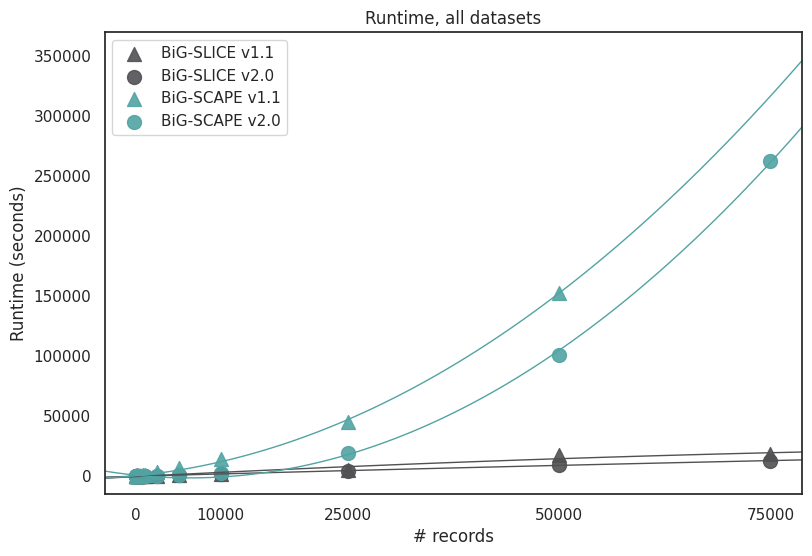

In [45]:
fig, axes = plt.subplots(1, 1, figsize=(9, 6))

### total runtimes, all sizes


## a) total runtimes for all sample sizes

## trend lines first
# bigslice v1
sns.regplot(
    label="BiG-SLICE v1.1",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SLICE v1.1")],
    x="size",
    y="total",
    marker="^",
    color=COLORS["bigslice_grey"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    scatter_kws=scatter_kws_default,
    ci=None,
)
# bigslice v2
sns.regplot(
    label="BiG-SLICE v2.0",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SLICE v2.0")],
    x="size",
    y="total",
    marker="o",
    color=COLORS["bigslice_grey"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    scatter_kws=scatter_kws_default,
    ci=None,
)
# bigscape v1
sns.regplot(
    label="BiG-SCAPE v1.1",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SCAPE v1.1")],
    x="size",
    y="total",
    marker="^",
    color=COLORS["bigscape_blue"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    scatter_kws=scatter_kws_default,
    ci=None,
)
# bigscape v2
sns.regplot(
    label="BiG-SCAPE v2.0",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SCAPE v2.0")],
    x="size",
    y="total",
    marker="o",
    color=COLORS["bigscape_blue"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    scatter_kws=scatter_kws_default,
    ci=None,
)

# title
axes.set_title("Runtime, all datasets")

# x axis options
axes.set_xlabel("# records")
axes.set_xticks([0, 10000, 25000, 50000, 75000])

# y axis options
axes.set_ylabel("Runtime (seconds)")

# legend
axes.legend(loc="upper left")


# axes[0, 0].set_xlim(0, 75000)
axes.set_ylim(-15000, 370000)

## b) total runtimes for sample sizes <= 10000
# generate plot

fig.savefig("Figure_3_a_record_vs_runtime_full.svg")

/tmp/ipykernel_24931/3541519683.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=totals[totals["Tool"].str.contains("BiG-SLICE v1.1")][totals["size"] <= 10000],
/tmp/ipykernel_24931/3541519683.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=totals[totals["Tool"].str.contains("BiG-SLICE v2.0")][totals["size"] <= 10000],
/tmp/ipykernel_24931/3541519683.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=totals[totals["Tool"].str.contains("BiG-SCAPE v1.1")][totals["size"] <= 10000],
/tmp/ipykernel_24931/3541519683.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=totals[totals["Tool"].str.contains("BiG-SCAPE v2.0")][totals["size"] <= 10000],


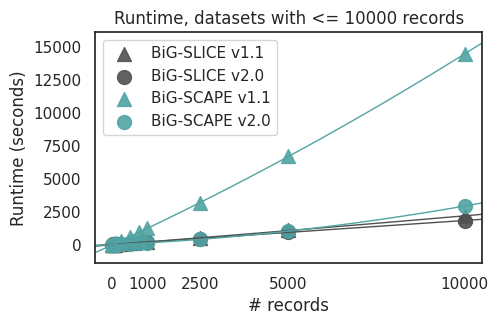

In [46]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))

## b) total runtimes for sample sizes <= 10000
# generate plot

## trend lines first
# bigslice v1
sns.regplot(
    label="BiG-SLICE v1.1",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SLICE v1.1")][totals["size"] <= 10000],
    x="size",
    y="total",
    marker="^",
    color=COLORS["bigslice_grey"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    scatter_kws=scatter_kws_default,
    ci=None,
)
# bigslice v2
sns.regplot(
    label="BiG-SLICE v2.0",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SLICE v2.0")][totals["size"] <= 10000],
    x="size",
    y="total",
    marker="o",
    color=COLORS["bigslice_grey"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    scatter_kws=scatter_kws_default,
    ci=None,
)
# bigscape v1
sns.regplot(
    label="BiG-SCAPE v1.1",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SCAPE v1.1")][totals["size"] <= 10000],
    x="size",
    y="total",
    marker="^",
    color=COLORS["bigscape_blue"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    scatter_kws=scatter_kws_default,
    ci=None,
)
# bigscape v2
sns.regplot(
    label="BiG-SCAPE v2.0",
    ax=axes,
    data=totals[totals["Tool"].str.contains("BiG-SCAPE v2.0")][totals["size"] <= 10000],
    x="size",
    y="total",
    marker="o",
    color=COLORS["bigscape_blue"],
    truncate=False,
    order=2,
    line_kws={"linewidth": 1},
    scatter_kws=scatter_kws_default,
    ci=None,
)

# title
axes.set_title("Runtime, datasets with <= 10000 records")

# x axis options
axes.set_xlabel("# records")
axes.set_xticks([0, 1000, 2500, 5000, 10000])

# y axis options
axes.set_ylabel("Runtime (seconds)")

# legend
axes.legend(loc="upper left")

fig.savefig("Figure_3_a_records_vs_runtime_subplot.svg", pad_inches=0.5, bbox_inches="tight")

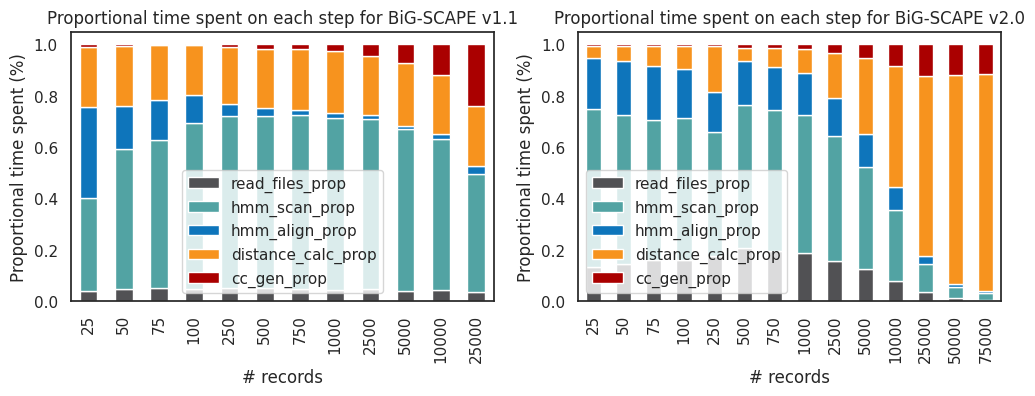

In [47]:

### runtime proportional time spent
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))


## c) proportional time spent on each step for v1
# generate plot
v1_prop_time_colors = [
    COLORS["bigslice_grey"],
    COLORS["bigscape_blue"],
    COLORS["dark_blue"],
    COLORS["orange_i_found_on_bigscape_image"],
    COLORS["antismash_red"]
]

# omit 10 samples
bigscape_v1_avg_prop = bigscape_v1_avg_prop.drop(10)

bigscape_v1_avg_prop.plot(ax=axes[0], kind='bar', stacked=True, color=v1_prop_time_colors)

# title
axes[0].set_title("Proportional time spent on each step for BiG-SCAPE v1.1")

# x axis options
axes[0].set_xlabel("# records")

# y axis options
axes[0].set_ylabel("Proportional time spent (%)")

# set legend to be in the bottom center
axes[0].legend(loc="lower center", bbox_to_anchor=(0.5, 0.0))

## d) proportional time spent on each step for v2
# generate plot
v2_prop_time_colors = [
    COLORS["bigslice_grey"],
    COLORS["bigscape_blue"],
    COLORS["dark_blue"],
    COLORS["orange_i_found_on_bigscape_image"],
    COLORS["antismash_red"],
]

# omit 10 samples
bigscape_v2_avg_prop = bigscape_v2_avg_prop.drop(10)

bigscape_v2_avg_prop.plot(ax=axes[1], kind='bar', stacked=True, color=v2_prop_time_colors)

# title
axes[1].set_title("Proportional time spent on each step for BiG-SCAPE v2.0")

# x axis options
axes[1].set_xlabel("# records")

# y axis options
axes[1].set_ylabel("Proportional time spent (%)")

# set legend to be in the bottom left
axes[1].legend(loc="lower left", bbox_to_anchor=(0.0, 0.0))



# save as svg
fig.savefig("Figure_3_b_prop_runtimes.svg", pad_inches=0.5, bbox_inches="tight")